# 04 Preparación de Datos de Entrenamiento

Este notebook se centra en la preparación de los datos necesarios para el entrenamiento de un modelo de detección de balsas utilizando imágenes aéreas PNOA. El proceso incluye el cálculo de Bounding Boxes (BB) y Oriented Bounding Boxes (OBB) para las geometrías de las balsas, la generación de cuadrados de recorte de tamaño fijo que contienen estas balsas y la extracción de los correspondientes recortes de las imágenes ráster. Finalmente, se crean las etiquetas en formato YOLOv8-OBB, listas para ser utilizadas en el entrenamiento del modelo

**Objetivo**: Preparar los datos vectoriales de balsas y las imágenes ráster PNOA para el entrenamiento de un modelo de detección de objetos (YOLOv8-OBB).

**Contenido**:

* Cálculo de Geometrías de Bounding Box (BB) y Oriented Bounding Box (OBB): Determinación de las envolventes rectangulares mínimas y orientadas para cada polígono de balsa.
* Generación de Cuadrados de Recorte: Creación de teselas cuadradas de tamaño fijo (640x640 píxeles) que contienen las geometrías de las balsas, optimizadas para el entrenamiento de modelos CNN.
* Recorte de Imágenes Ráster: Extracción de porciones de las imágenes PNOA utilizando las geometrías de los cuadrados de recorte generados, guardando cada recorte como un archivo GeoTIFF.
* Creación de Etiquetas en Formato YOLOv8-OBB: Generación de archivos de texto con las coordenadas normalizadas de los vértices de los OBB de las balsas dentro de cada recorte de imagen, listas para el entrenamiento del modelo.
* Visualización de Resultados Intermedios: Representación espacial de las balsas, sus OBB y los cuadrados de recorte en un mapa interactivo.

## Importamos librerias necesarias

In [1]:
# Instalar las librerias necesarias
# !pip install xxxxxxx

In [2]:
# Importar librerias necesarias
import geopandas as gpd
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import folium
from osgeo import gdal
import os
from shapely.geometry import Polygon, box
from rtree.index import Index
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


## Recortes de imágenes

Para preparar los datos de entrada del modelo de detección de balsas, en este notebook se realizarán una serie de cálculos sobre las geometrías de las balsas, incluyendo la obtención de bounding boxes y oriented bounding boxes..

* **Obtención de coordenadas de Bounding Box (BB):** Se calculan las coordenadas de la envolvente rectangular mínima (Bounding Box - BB) para cada polígono de balsa, definiendo así sus límites ortogonales..

* **Obtención de coordenadas de Oriented Bounding Box (OBB):** Se calculan las envolventes rectangulares orientadas (Oriented Bounding Box - OBB) para cada balsa, ajustándose a su orientación espacial. Esto proporciona una delimitación más precisa que los BB.

* **Calcular las coordenadas finales del recorte ajustándolas al tamaño de píxel:** Asegurarse de que las coordenadas de los recortes se alineen con la resolución de los píxeles de las imágenes. Esto garantiza recortes precisos y evita problemas al procesar las imágenes e interpolaciones en los pixeles qeu puedan alterar el valor original del mismo.

In [3]:
# Cargamos las balsas en un gdf
gdf = gpd.read_file("../data/interim/btn_balsa_en_uso.gpkg")

In [4]:
# Calcular los centroides de los polígonos
centroides = gdf.geometry.centroid

# Extraer las coordenadas x e y del centroide y las guarda en columnas
gdf['x_centroide'] = centroides.x
gdf['y_centroide'] = centroides.y

In [5]:
# Añadir los bounds (coordenadas del BB envolvente mínima) como nuevas columnas a las balsas
gdf[['x_min', 'y_min', 'x_max', 'y_max']] = gdf.geometry.bounds

In [6]:
# Calculamos y añadimos al gdf las coordenadas del centro de los bounds
gdf['x_centro'] = (gdf['x_min'] + gdf['x_max']) / 2
gdf['y_centro'] = (gdf['y_min'] + gdf['y_max']) / 2

In [7]:
# Ajustamos las coordenadas del centro a los pixeles de las imágenes (1 m. de píxel)
def ajustar_a_multiplo_cercano(coordenada, tamano_pixel=1):
    return round(coordenada / tamano_pixel) * tamano_pixel

# Ajustar las coordenadas a los límites de los píxeles
gdf['x_centro'] = gdf['x_centro'].apply(ajustar_a_multiplo_cercano)
gdf['y_centro'] = gdf['y_centro'].apply(ajustar_a_multiplo_cercano)

### Obtención de coordenadas de Oriented Bounding Box (OBB)

Para obtenr los OBB a partir de las geometías de los polígonos de las balsas creamos la sigiuente función para: 

* Calcula el rectángulo orientado mínimo (OBB) para cada polígono
* Ordena los vértices en sentido horario empezando por la esquina superior izquierda
* Actualiza tanto las coordenadas individuales como la geometría del polígono

In [8]:
def crear_obb_con_vertices_ordenados(gdf):
    """
    Crea un gdf con los OBBs (Oriented Bounding Boxes) de los polígonos
    originales, extrayendo y ordenando las coordenadas de los vértices en sentido horario,
    comenzando por la esquina superior izquierda.
    
    Args:
        gdf: gdf con los polígonos originales.
    Returns:
        gdf con los OBBs ordenados y las coordenadas de sus vértices.
    """
    # Crear copia y calcular OBBs
    obb_gdf = gdf.copy()
    obb_gdf["geometry"] = obb_gdf["geometry"].apply(
        lambda polygon: polygon.minimum_rotated_rectangle if polygon.is_valid and not polygon.is_empty else None
    )
    
    # Inicializar las columnas para las coordenadas ordenadas
    for i in range(1, 5):
        obb_gdf[f"obb_x{i}"] = np.nan
        obb_gdf[f"obb_y{i}"] = np.nan
    
    # Procesar cada polígono
    for idx, row in obb_gdf.iterrows():
        if row.geometry is None:
            continue
            
        # Extraer coordenadas (sin el vértice repetido)
        vertices = np.array(list(row.geometry.exterior.coords)[:-1])
        
        # Calcular el centro
        center = np.mean(vertices, axis=0)
        
        # Calcular ángulos respecto al centro
        angles = np.arctan2(vertices[:, 1] - center[1], vertices[:, 0] - center[0])
        
        # Ordenar en sentido horario
        sorted_indices = np.argsort(-angles)
        ordered_vertices = vertices[sorted_indices]
        
        # Identificar top-left: mayor Y, en caso de empate menor X
        top_left_idx = np.lexsort((ordered_vertices[:, 0], -ordered_vertices[:, 1]))[0]
        
        # Rotar para que top-left sea el primero
        ordered_vertices = np.roll(ordered_vertices, -top_left_idx, axis=0)
        
        # Actualizar GeoDataFrame con coordenadas ordenadas
        for i in range(4):
            obb_gdf.loc[idx, f"obb_x{i+1}"] = ordered_vertices[i, 0]
            obb_gdf.loc[idx, f"obb_y{i+1}"] = ordered_vertices[i, 1]
        
        # Actualizar geometría
        poly_coords = ordered_vertices.tolist()
        poly_coords.append(poly_coords[0])  # Cerrar el polígono
        obb_gdf.loc[idx, 'geometry'] = Polygon(poly_coords)
    
    return obb_gdf

In [9]:
# Llamamos a la función
obb_gdf = crear_obb_con_vertices_ordenados(gdf)

In [10]:
# Quitamos campos innecesarios
obb_gdf = obb_gdf[['ID', 'area_m2', 'HMTN25', 'geometry', 'x_centroide', 'y_centroide',
       'obb_x1', 'obb_y1', 'obb_x2', 'obb_y2', 'obb_x3', 'obb_y3', 'obb_x4', 'obb_y4']]

In [11]:
# Eliminamos posibles filas duplicadas
obb_gdf = obb_gdf.drop_duplicates()

In [12]:
# Guarda el gdf con las geometrias obb en formato gpkg
obb_gdf.to_file("../data/interim/envolventes_obb_balsas.gpkg", driver="GPKG")

In [13]:
print(obb_gdf.shape)
obb_gdf.head(3)

(202, 14)


,ID,area_m2,HMTN25,geometry,x_centroide,y_centroide,obb_x1,obb_y1,obb_x2,obb_y2,obb_x3,obb_y3,obb_x4,obb_y4
0,246804697,3857.247349,0963_3,"POLYGON ((249521.009 4153806.301, 249613.938 4...",249559.971787,4.153773e+06,249521.009478,4.153806e+06,249613.937887,4.153801e+06,249610.700638,4.153747e+06,249517.772229,4.153752e+06
1,246797997,5915.347125,0963_3,"POLYGON ((249972.217 4154372.202, 250071.625 4...",250011.490290,4.154312e+06,249972.216524,4.154372e+06,250071.625102,4.154326e+06,250040.223408,4.154258e+06,249940.814830,4.154305e+06
2,246805875,1455.975963,0963_3,"POLYGON ((249949.128 4154385.654, 249968.633 4...",249936.440519,4.154356e+06,249949.127502,4.154386e+06,249968.632502,4.154360e+06,249926.498497,4.154328e+06,249906.993497,4.154354e+06


#### Visualización de una muestra de los poligonos y los OBB

Generaremos unos graficos aleatorios con las geometrías originales y los obb generados para comparar el ajuste entre ambos

In [14]:
def plot_geodataframes_sample(gdf, obb_gdf, n_samples=6):
    """
    Visualiza una muestra aleatoria de 6 pares de polígonos originales y sus OBBs ordenados,
    en una cuadrícula de 2 filas x 3 columnas. Cada vértice del OBB está numerado.
    El polígono original se dibuja sobre el OBB para mejor visibilidad.
    
    Args:
        gdf (geopandas.GeoDataFrame): GeoDataFrame con los polígonos originales.
        obb_gdf (geopandas.GeoDataFrame): GeoDataFrame con los OBBs ordenados.
        n_samples (int): Número de muestras a visualizar (por defecto 6).
    """
    # Verificar que ambos GeoDataFrames tienen el mismo número de elementos
    if len(gdf) != len(obb_gdf):
        raise ValueError("Los GeoDataFrames deben tener el mismo número de elementos.")
    
    # Seleccionar índices aleatorios
    if len(gdf) <= n_samples:
        indices = np.arange(len(gdf))
    else:
        indices = np.random.choice(len(gdf), n_samples, replace=False)
    
    # Crear figura con subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Mapa de colores
    cmap = plt.cm.tab10
    
    # Visualizar cada par de geometrías
    for i, idx in enumerate(indices):
        ax = axes[i]
        
        # Primero dibujar OBB (debajo)
        obb_gdf.iloc[[idx]].plot(ax=ax, facecolor=cmap(1), alpha=0.4, edgecolor="red")
        
        # Después dibujar polígono original (encima)
        gdf.iloc[[idx]].plot(ax=ax, facecolor=cmap(0), alpha=0.6, edgecolor="black")
        
        # Numerar vértices del OBB (excluyendo el último punto que es igual al primero)
        obb_coords = list(obb_gdf.iloc[idx].geometry.exterior.coords)[:-1]
        for j, (x, y) in enumerate(obb_coords):
            ax.text(x, y, str(j+1), fontsize=12, fontweight='bold', ha='center', va='center', 
                   color='blue', bbox=dict(facecolor='white', alpha=0.8, pad=2, boxstyle='round,pad=0.5'))
        
        # Configurar gráfico
        ax.set_title(f"Muestra {idx+1}", fontsize=12)
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Añadir un borde al subplot 
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)
    
    # Añadir leyenda común
    handles = [
        mpatches.Patch(facecolor=cmap(0), alpha=0.6, label="Polígono Original", edgecolor="black"),
        mpatches.Patch(facecolor=cmap(1), alpha=0.4, label="OBB Ordenado", edgecolor="red")
    ]
    fig.legend(handles=handles, loc='lower center', ncol=2, fontsize=12, 
              bbox_to_anchor=(0.5, 0.02), frameon=True, framealpha=1)
    
    plt.suptitle("Muestra de los OBB y sus vértices ordenados en sentido horario y los Polígonos Originales", fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1, top=0.92)  # Espacio para la leyenda y título
    
    return fig

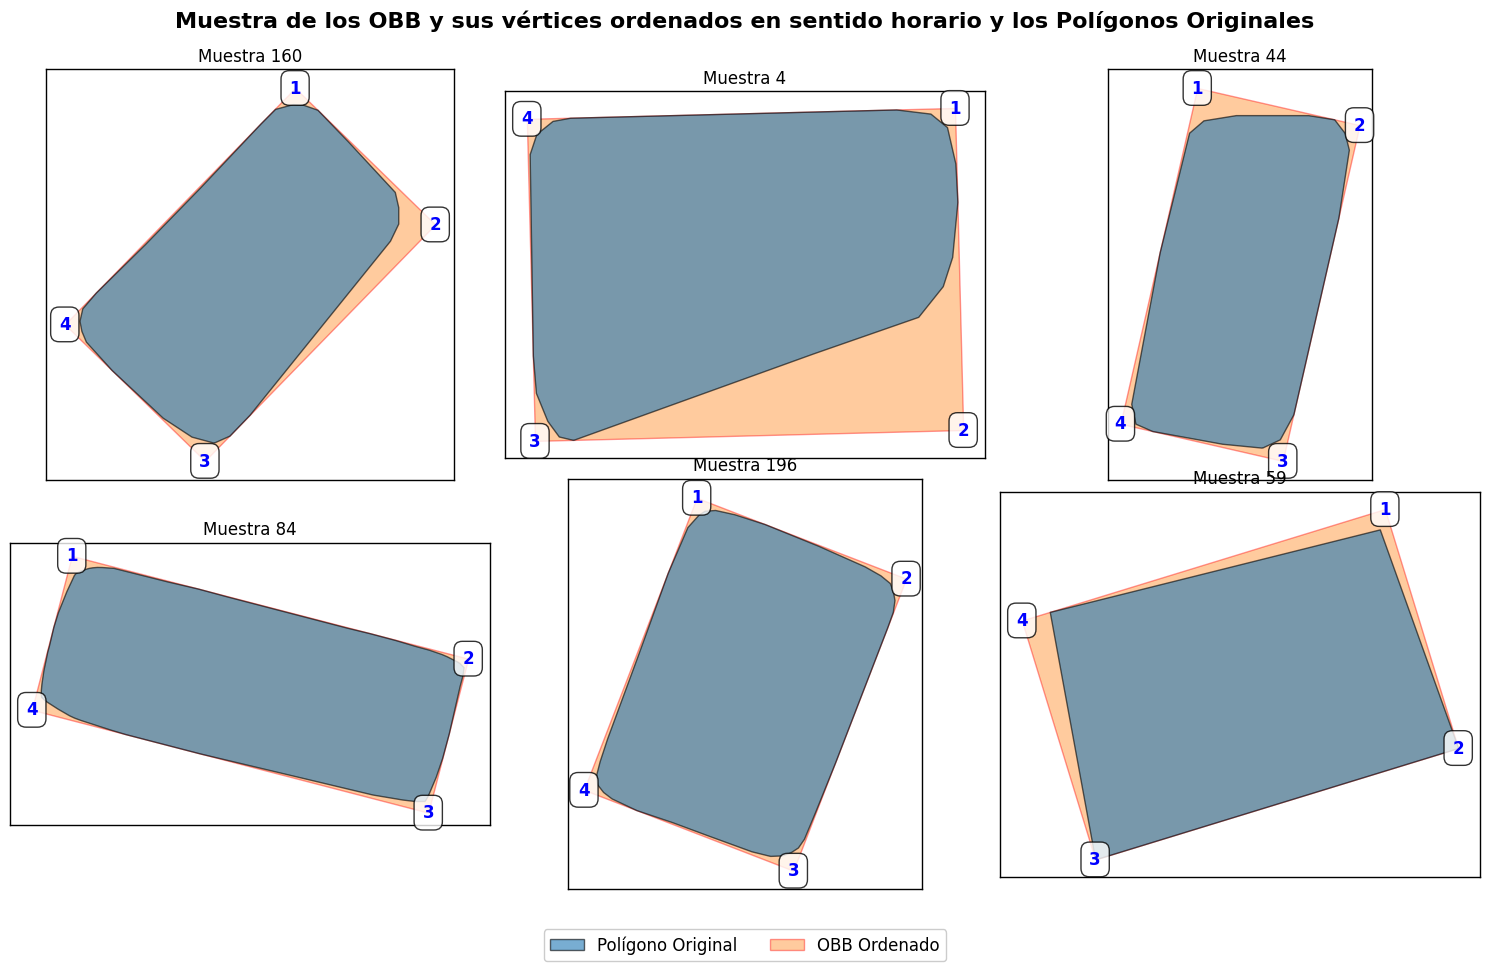

In [15]:
# Mostramos la figura generada por la función
fig = plot_geodataframes_sample(gdf, obb_gdf)
plt.show()

# Para guardar la figura
#fig.savefig("comparacion_obbs.png", dpi=300, bbox_inches="tight")

Por lo general, los OBB tienen un mejor ajuste qeu los BB a la diposición espacialmente aleatoria de las balsas.

### Obtener cuadrados de recorte

Se generan cuadrados de recorte de tamaño fijo (640x640 píxeles) que contienen las balsas. Este tamaño es óptimo para arquitecturas de CNN como YOLOv8, asegurando eficiencia computacional y compatibilidad con modelos pre-entrenados.

In [16]:
# Parámetros
LADO_CUADRADO = 640  # Tamaño del cuadrado en píxeles (640 o 1280)
FACTOR_BUFFER = 1.5  # Factor para búsqueda de candidatos

# Crear índice espacial
spatial_index = Index()
for idx, geom in obb_gdf.geometry.items():
    spatial_index.insert(idx, geom.bounds)

def cuadrados_con_bounds(bounds):
    """
    Crea un cuadrado de LADO_CUADRADO que contenga los límites dados.
    Asegura que las coordenadas del centro sean enteras para que los límites
    del cuadrado también sean enteros.
    """
    minx, miny, maxx, maxy = bounds

    # Calcular centro y redondear
    cx = round((minx + maxx) / 2)
    cy = round((miny + maxy) / 2)

    # Asegurar que el cuadrado tenga exactamente LADO_CUADRADO
    half_size = LADO_CUADRADO / 2
    return box(cx - half_size, cy - half_size, cx + half_size, cy + half_size)

def caben_en_cuadrado(geoms):
    """
    Verifica si un grupo de geometrías caben en un cuadrado de LADO_CUADRADO
    """
    if not geoms:
        return False
    minx = min(g.bounds[0] for g in geoms)
    miny = min(g.bounds[1] for g in geoms)
    maxx = max(g.bounds[2] for g in geoms)
    maxy = max(g.bounds[3] for g in geoms)
    return (maxx - minx <= LADO_CUADRADO) and (maxy - miny <= LADO_CUADRADO)

def minimizar_cuadrados(obb_gdf):
    """
    Agrupa geometrías en cuadrados óptimos minimizando la cantidad de cuadrados finales.
    """
    cuadrados = []
    pol_pendientes = set(obb_gdf.index)
    spatial_index = Index()
    for idx, geom in obb_gdf.geometry.items():
        spatial_index.insert(idx, geom.bounds)

    while pol_pendientes:
        # Tomar primer elemento
        idx_actual = pol_pendientes.pop()
        pol_actual = obb_gdf.loc[idx_actual].geometry
        grupo = [pol_actual]
        grupo_indices = {idx_actual}

        # Buscar candidatos en área expandida
        buffer_size = LADO_CUADRADO * FACTOR_BUFFER
        bounds_busqueda = pol_actual.buffer(buffer_size).bounds
        candidatos = spatial_index.intersection(bounds_busqueda)
        candidatos = [i for i in candidatos if i in pol_pendientes]

        # Evaluar candidatos
        for candidato_idx in candidatos:
            candidato_geom = obb_gdf.loc[candidato_idx].geometry
            temp_grupo = grupo + [candidato_geom]

            if caben_en_cuadrado(temp_grupo):
                grupo.append(candidato_geom)
                grupo_indices.add(candidato_idx)
                pol_pendientes.remove(candidato_idx)

        # Crear cuadrado óptimo
        minx = min(g.bounds[0] for g in grupo)
        miny = min(g.bounds[1] for g in grupo)
        maxx = max(g.bounds[2] for g in grupo)
        maxy = max(g.bounds[3] for g in grupo)
        cuadrado = cuadrados_con_bounds((minx, miny, maxx, maxy))
        cuadrados.append(cuadrado)

        # Marcar geometrías cubiertas por el cuadrado
        cuadrado_bounds = cuadrado.bounds
        candidatos_en_cuadrado = spatial_index.intersection(cuadrado_bounds)
        for idx in candidatos_en_cuadrado:
            if idx in pol_pendientes and cuadrado.contains(obb_gdf.loc[idx].geometry):
                pol_pendientes.remove(idx)

    return cuadrados

def contar_poligonos_en_cuadrados(obb_gdf, cuadrados):
    """
    Cuenta el número de polígonos completamente contenidos en cada cuadrado y almacena los IDs.
    """
    gdf_cuadrados = gpd.GeoDataFrame(geometry=cuadrados, crs=obb_gdf.crs)
    gdf_cuadrados['n_obb'] = 0
    gdf_cuadrados['IDs'] = [[] for _ in range(len(cuadrados))]

    for idx, cuadrado in gdf_cuadrados.iterrows():
        contenidos = obb_gdf[obb_gdf.geometry.within(cuadrado.geometry)]
        gdf_cuadrados.at[idx, 'n_obb'] = len(contenidos)
        gdf_cuadrados.at[idx, 'IDs'] = contenidos['ID'].tolist()

    return gdf_cuadrados

# Generar cuadrados
cuadrados = minimizar_cuadrados(obb_gdf)

# Contar polígonos en cuadrados
gdf_cuadrados = contar_poligonos_en_cuadrados(obb_gdf, cuadrados)

# Guardar GeoDataFrame de cuadrados
gdf_cuadrados.to_file('../data/interim/cuadrados_recorte_balsas.gpkg', driver="GPKG")

print(f"Se generaron {len(cuadrados)} cuadrados de recorte")


Se generaron 143 cuadrados de recorte


In [17]:
# Visualización de las primeras filas de gdf
gdf_cuadrados.head(3)

,geometry,n_obb,IDs
0,"POLYGON ((250115 4153746, 250115 4154386, 2494...",3,"[246804697, 246797997, 246805875]"
1,"POLYGON ((250574 4154392, 250574 4155032, 2499...",3,"[246804653, 246804650, 246810303]"
2,"POLYGON ((251206 4154915, 251206 4155555, 2505...",4,"[246810783, 246796762, 246804161, 246796761]"


El modelo de detección de balsas que vamos a utilizar (*Yolov8-obb*) está optimizado para trabajar en el etrenamiento con imagenes cuadradas de 640x640 píxeles por lo que los cuadrados de recorte que superen esas dimesiones los descartaremos. 

Si los obb no entran dentro de los cuadrados de recorte el contandor del campo n_obb será = 0. Comprobamos cuantos cuadrados de recorte no contienen obb y los eliminamos.

In [18]:
# Nº de cuadrados de recorte que no pueden contener los obb de las balsas del interior
print("Nº Cuadrados de recorte sin obb:", len(gdf_cuadrados[gdf_cuadrados['n_obb'] == 0]))

Nº Cuadrados de recorte sin obb: 1


In [19]:
# Filtrar eliminando los registros donde 'n_obb' sea igual a 0
gdf_cuadrados = gdf_cuadrados[gdf_cuadrados['n_obb'] != 0]

### Recortar VRT de las imágenes PNOA por cuadrados de recorte (GeoTIFF)

Se utiliza la función recortar_vrt para extraer los recortes de las imágenes PNOA del VRT generado previamente, utilizando las geometrías de los cuadrados definidos. Cada recorte se guarda como un archivo GeoTIFF individual en la ruta especificada.

In [20]:
%%time
# Definimos las funciones para realizar los recortes de las imágenes
def recortar_vrt(gdf_clip, ruta_vrt, ruta_salida, formato='tif'):
    """
    Recorre un GeoDataFrame con geometrías de cuadrados y recorta el VRT
    guardando cada recorte como TIFF con su información geoespacial interna.
    Optimizado para archivos de entrenamiento de ML.
    
    Args:
        gdf_clip (GeoDataFrame): GeoDataFrame con geometrías de cuadrados
        ruta_vrt (str): Ruta al archivo VRT a recortar
        ruta_salida (str): Carpeta donde guardar los recortes
        formato (str): Formato de salida (por defecto 'tif')
    """
    # Crear directorio de salida si no existe
    os.makedirs(ruta_salida, exist_ok=True)
    
    # Configurar opciones de GDAL
    gdal.UseExceptions()  # Habilitar excepciones
    gdal.SetConfigOption('GDAL_TIFF_INTERNAL_MASK', 'YES')
    gdal.SetConfigOption('GDAL_RASTERIO_RESAMPLING', 'NEAREST')
    
    # Abrir el VRT
    vrt_ds = gdal.Open(ruta_vrt)
    if vrt_ds is None:
        raise ValueError(f"No se pudo abrir el archivo VRT: {ruta_vrt}")
    
    try:
        # Obtener información del VRT
        srs = vrt_ds.GetProjection()
        band_count = vrt_ds.RasterCount
        
        # Opciones de creación para TIFF
        driver_name = 'GTiff'
        opciones_creacion = [
            'COMPRESS=LZW',
            'TILED=NO',
            'INTERLEAVE=PIXEL',
            'TFW=NO',
            'PREDICTOR=2'
        ]
        
        # Recorrer cada geometría en el GeoDataFrame con barra de progreso
        for idx, row in tqdm(gdf_clip.iterrows(), total=len(gdf_clip), desc="Recortando geometrías"):
            try:
                # Obtener los límites de la geometría
                minx, miny, maxx, maxy = row.geometry.bounds
                
                # Generar nombre de archivo
                id_valor = str(row.get('ID', idx))  # Usar 'ID' si existe, o el índice
                nombre_archivo = f"{id_valor}.{formato}"
                ruta_archivo = os.path.join(ruta_salida, nombre_archivo)
                
                # Realizar el recorte usando GDAL Translate
                gdal.Translate(
                    ruta_archivo,
                    vrt_ds,
                    projWin=[minx, maxy, maxx, miny],
                    format=driver_name,
                    creationOptions=opciones_creacion,
                    resampleAlg=gdal.GRA_NearestNeighbour,
                    outputSRS=srs
                )
                
            except Exception as e:
                print(f"Error al procesar la geometría {idx}: {str(e)}")
    
    finally:
        # Cerrar el dataset VRT
        vrt_ds = None



CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


In [21]:
# Definimos variables y llamamos a la función recortar_vrt
ruta_vrt = "../data/interim/pnoa/VRT_PNOA_IRG.vrt"
ruta_salida = "../data/interim/dataset/images"
gdf_clip = gdf_cuadrados

recortar_vrt(gdf_clip, ruta_vrt, ruta_salida, formato='tif')

Recortando geometrías:   0%|          | 0/142 [00:00<?, ?it/s]

## Comprobar imagenes

* Si hacemos una comprobación aleatoria de algunas de las recortes de las imágenes, aún es facil encontrar algunas de ellas en las que no figuaran balsas, o estan secas o estan abandonadas o corresponden con otras estructuras.
* Hay que recordar que la categoría la categoría de los polígonos de la cartografía BTN para estas entidades es de Balsas/Albercas/Estanques, por lo que sería recomendable refinar la selección de geometrías 

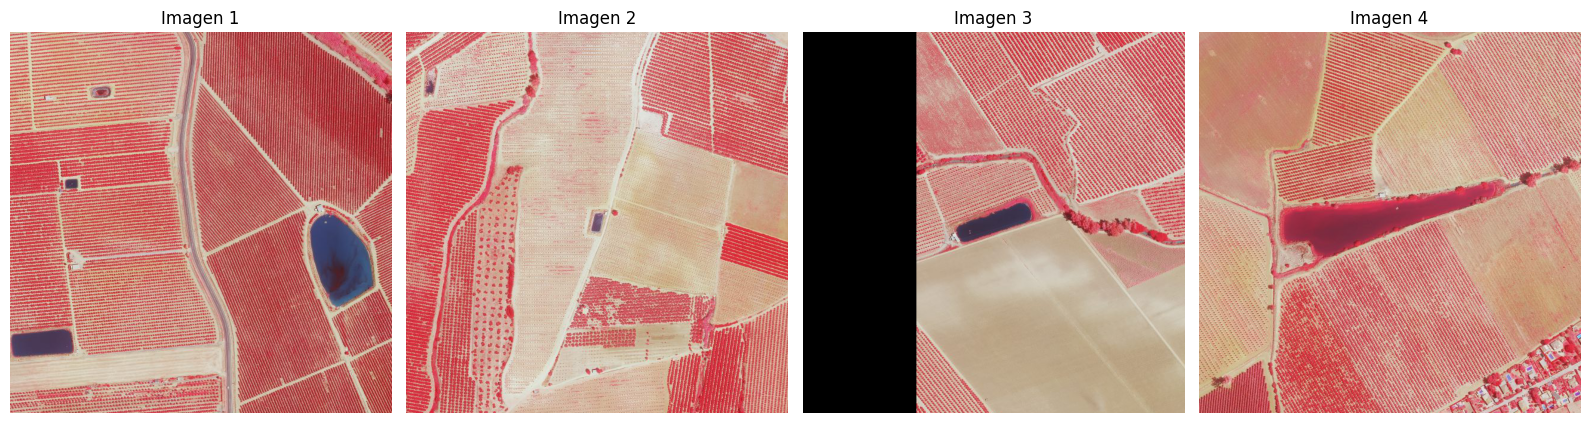

In [22]:
# ruta_salida = "../data/interim/dataset/images"

# Obtener una lista de todas las imágenes .tif en el directorio donde guardamos los recortes
image_files = [f for f in os.listdir(ruta_salida) if f.endswith('.tif')]

# Seleccionar aleatoriamente 6 imágenes
sample_images = random.sample(image_files, 4)

# Crear una figura con 2 filas y 3 columnas
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

# Mostrar las imágenes seleccionadas
for i, ax in enumerate(axes.flatten()):
    img_path = os.path.join(ruta_salida, sample_images[i])
    img = Image.open(img_path)  # Abrir la imagen
    ax.imshow(img)
    ax.axis('off')  # Ocultar los ejes
    ax.set_title(f"Imagen {i+1}")  # Título opcional

# Ajustar el diseño
plt.tight_layout()
plt.show()

## Crear las labels OBB

Las labels (etiquetas) son esenciales para los modelos de detección de objetos, ya que proporcionan información precisa sobre las posiciones y categorías de los objetos en las imágenes. Estas etiquetas permiten al modelo aprender a identificar y localizar los objetos de interés durante el proceso de entrenamiento, lo que es crucial para su precisión y desempeño en tareas de predicción.

Diferencias entre labels de Bounding Box (**BB**) y Oriented Bounding Box (**OBB**)

* Bounding Box (BB):
    * Es un rectángulo alineado con los ejes X e Y que rodea al objeto de interés.
    * Es más simple de calcular y manejar, pero puede incluir áreas innecesarias (fondo) si el objeto no tiene una orientación paralela a los ejes.
    * Utilizado en la mayoría de los modelos básicos de detección, como YOLO estándar.

* Oriented Bounding Box (OBB):
    * Es un rectángulo rotado que se ajusta mejor a la forma y orientación del objeto.
    * Es más preciso para objetos alargados o rotados, como vehículos, edificios o balsas.
    * Requiere más complejidad para su cálculo y entrenamiento, y es necesario especificar el ángulo de rotación.
    * Es ideal para aplicaciones en las que la orientación del objeto es relevante, como en imágenes aéreas.

**En el contexto de YOLOv8**

YOLOv8 admite etiquetas estándar de BB, pero para casos específicos, como detección de objetos orientados, se pueden utilizar extensiones o adaptaciones del modelo que soporten OBB.

Las etiquetas adecuadas permiten al modelo generalizar mejor y mejorar su precisión en aplicaciones específicas, como la detección de balsas en imágenes aéreas.

Las etiquetas (labels) en **YOLOv8** se definen en archivos de texto (.txt), donde cada línea representa un objeto en una imagen. Los valores están normalizados (entre 0 y 1) con respecto a las dimensiones de la imagen. 

### Oriented Bounding Box (OBB): Formato orientado
Para OBB, es necesario incluir información adicional sobre la orientación del rectángulo. El formato puede variar según la implementación, pero para Yolov8-obb sigue esta estructura:

```
<class_index> <x1> <y1> <x2> <y2> <x3> <y3> <x4> <y4>
```

- **`class_id`**: Identificador de la clase del objeto (entero).
- **`x1`**: Coordenada X del primer vértide de la caja orientada (normalizada entre 0 y 1).
- **`y1`**: Coordenada Y del primer vértide de la caja orientada (normalizada entre 0 y 1).
- **`x2`**: Coordenada X del segundo vértide de la caja orientada (normalizada entre 0 y 1).
- **`y2`**: Coordenada Y del segundo vértide de la caja orientada (normalizada entre 0 y 1).
- **`x3`**: Coordenada Y del tercer vértide de la caja orientada (normalizada entre 0 y 1).
- **`y3`**: Coordenada Y del tercer vértide de la caja orientada (normalizada entre 0 y 1).
- **`x4`**: Coordenada X del cuarto vértide de la caja orientada (normalizada entre 0 y 1).
- **`y4`**: Coordenada Y del cuarto vértide de la caja orientada (normalizada entre 0 y 1).

Los vértices del OBB deben estar ordenados empezando por el top-left (el de más arriba y más a la izquierda) y seguir en sentido horario

In [23]:
%%time
def crear_etiquetas_yolo_obb(gdf_cuadrados, obb_gdf, directorio_salida, clase=0):
    """
    Método para crear etiquetas YOLOv8-OBB (Oriented Bounding Box), considerando:
    1. La inversión del eje Y entre coordenadas geográficas e imágenes
    2. Las coordenadas de los vértices en sentido horario empezando por el top-left
    3. La normalización adecuada de coordenadas geográficas a coordenadas relativas

    Args:
        gdf_cuadrados: GeoDataFrame con los datos de los cuadrados
        obb_gdf: GeoDataFrame con las coordenadas OBB
        directorio_salida: Directorio donde se guardarán los archivos de etiquetas
        clase: Clase del objeto (por defecto 0)
    """
    # Crear directorio si no existe
    os.makedirs(directorio_salida, exist_ok=True)

    # Lista de los campos OBB
    campos_obb = ['obb_x1', 'obb_y1', 'obb_x2', 'obb_y2', 'obb_x3', 'obb_y3', 'obb_x4', 'obb_y4']

    # Verificar que los campos OBB existen en el GeoDataFrame
    for campo in campos_obb:
        if campo not in obb_gdf.columns:
            raise ValueError(f"El campo {campo} no existe en el GeoDataFrame OBB")

    # Tamaño fijo del recorte en metros
    ancho_recorte_geo = 640
    alto_recorte_geo = 640

    # Recorrer filas de gdf_cuadrados y escribir archivos
    for i, cuadrado in tqdm(gdf_cuadrados.iterrows(), total=len(gdf_cuadrados), desc="Generando etiquetas OBB"):
        # Obtener las coordenadas mínimas y máximas del polígono
        x_min_clip, y_min_clip, x_max_clip, y_max_clip = cuadrado['geometry'].bounds

        # Crear contenido del archivo de etiqueta
        contenido_archivo = []

        # Recorrer cada ID en el listado de IDs
        for id_obb in cuadrado['IDs']:
            # Obtener las coordenadas OBB correspondientes
            obb_coords = obb_gdf.loc[obb_gdf['ID'] == id_obb, campos_obb].values[0]

            # Normalizar las coordenadas del OBB
            coords_norm = []

            # Procesar coordenadas X
            for j in range(0, len(campos_obb), 2):
                # Normalizar X: (x - x_min_clip) / ancho_recorte
                x_norm = (obb_coords[j] - x_min_clip) / ancho_recorte_geo
                x_norm = np.clip(x_norm, 0, 1)
                coords_norm.append(x_norm)

            # Procesar coordenadas Y (invirtiendo el eje)
            for j in range(1, len(campos_obb), 2):
                # Normalizar Y e invertir: 1.0 - ((y - y_min_clip) / alto_recorte)
                y_norm = 1.0 - ((obb_coords[j] - y_min_clip) / alto_recorte_geo)
                y_norm = np.clip(y_norm, 0, 1)
                coords_norm.append(y_norm)

            # Reordenar para tener formato x1,y1,x2,y2,x3,y3,x4,y4
            coords_final = []
            for j in range(4):
                coords_final.append(coords_norm[j])        # x_j
                coords_final.append(coords_norm[j + 4])    # y_j

            # Añadir línea al contenido del archivo
            contenido_archivo.append(f"{clase} " + " ".join([f"{coord:.6f}" for coord in coords_final]))

        # Guardar en archivo
        archivo_salida = os.path.join(directorio_salida, f"{i}.txt")
        with open(archivo_salida, 'w') as f:
            f.write("\n".join(contenido_archivo))

    print(f"Se generaron {len(gdf_cuadrados)} etiquetas OBB en {directorio_salida}")

# Asignamos la ruta de salida y ejecutamos la función
directorio_salida_obb = '../data/interim/dataset/labels_obb'
crear_etiquetas_yolo_obb(gdf_cuadrados, obb_gdf, directorio_salida_obb)

Generando etiquetas OBB:   0%|          | 0/142 [00:00<?, ?it/s]

Se generaron 142 etiquetas OBB en ../data/interim/dataset/labels_obb
CPU times: user 156 ms, sys: 4.01 ms, total: 160 ms
Wall time: 163 ms


# Visualizaciones

Representamos en un mapa interactivo la distribución espacial de las balsas y los envolventes y los cuadrados para los recortes del ámbito de estudio.

### Visor de OBB y cuadrados de recorte

In [24]:
# Cargar el ambito de gpkg a gdf
ambito = gpd.read_file("../data/interim/pnoa_irg_ambito.gpkg")
balsas = gdf.copy(deep=True) # creamos copia independiente

# Reproyectamos los gdf a EPSG:4326 (latitud y longitud) para visualizarlas en Folium
ambito_4326 = ambito.to_crs(epsg=4326)[['geometry']]
balsas_4326 = balsas.to_crs(epsg=4326)[['geometry']]
obb_gdf_4326 = obb_gdf.to_crs(epsg=4326)[['geometry']]
gdf_cuadrados_4326 = gdf_cuadrados.to_crs(epsg=4326)[['geometry']]

In [25]:
# Crear mapa centrado en dissolve_marcos_irg
x, y = ambito_4326.geometry.centroid.x.mean(), ambito_4326.geometry.centroid.y.mean()
m = folium.Map(location=[y, x], zoom_start=10)

# Añadir WMS PNOA IRG
folium.WmsTileLayer(
    'https://www.ideandalucia.es/wms/ortofoto_2022?',
    layers='ortofotografia_2022_infrarrojo',
    fmt='image/jpeg',
    transparent=True,
    name='WMS Ortofoto IRG',
    control=True
).add_to(m)

# Añadir ambito_4326 con simbología (sin relleno, borde rojo grueso)
folium.GeoJson(
    ambito_4326,
    style_function=lambda x: {
        'fillColor': 'none',
        'color': 'green',
        'weight': 5
    },
    name="Ámbito"
).add_to(m)


# Añadir balsas_4326
folium.GeoJson(
    balsas_4326,
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'blue',
        'weight': 2,
        'fillOpacity': 0.5
    },
    name="Balsas"
).add_to(m)

# Añadir obb_gdf_4326
folium.GeoJson(
    obb_gdf_4326,
    style_function=lambda x: {
        'fillColor': 'yellow',
        'color': 'yellow',
        'weight': 2,
        'fillOpacity': 0.0
    },
    name="OBB"
).add_to(m)

# Añadir gdf_cuadrados_4326
folium.GeoJson(
    gdf_cuadrados_4326,
    style_function=lambda x: {
        'fillColor': 'cyan',
        'color': 'cyan',
        'weight': 3,
        'fillOpacity': 0.0
    },
    name="Cuadrados de recorte"
).add_to(m)

# Agregar el control de capas
folium.LayerControl(collapsed=False).add_to(m)

# Crear leyenda HTML
legend_html = """
<div style="
    position: fixed; 
    bottom: 50px; 
    right: 50px; 
    width: 200px; 
    height: auto; 
    border: 2px solid grey; 
    z-index: 9999; 
    font-size: 14px;
    background-color: white;
    padding: 10px;
    ">
    <b>Leyenda</b> <br>
    <i style="border: 4px solid green; width: 20px; height: 10px; display: inline-block;"></i> Ámbito <br>
    <i style="border: 2px solid blue; width: 20px; height: 10px; display: inline-block;"></i> Balsas <br>
    <i style="border: 2px solid yellow; width: 20px; height: 10px; display: inline-block;"></i> OBB <br>
    <i style="border: 3px solid cyan; width: 20px; height: 10px; display: inline-block;"></i> Cuadrados recorte <br>
</div>
"""

# Crear título HTML
titulo_html = """
<div style="
    position: fixed; 
    top: 10px; 
    left: 50%; 
    transform: translateX(-50%); 
    z-index: 1000; 
    font-size: 20px; 
    font-weight: bold;
    text-align: center; 
    background-color: white; 
    border: 2px solid black; 
    padding: 10px; 
    border-radius: 5px;
    box-shadow: 3px 3px 5px rgba(0,0,0,0.3);">
    Mapa interactivo:<br> Balsas, OBB y Cuadrados de recorte
</div>
"""

# Añadir leyenda al mapa
m.get_root().html.add_child(folium.Element(legend_html))

# Añadir título al mapa
m.get_root().html.add_child(folium.Element(titulo_html))

# Mostrar el mapa
m

/tmp/ipykernel_22273/1256744527.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x, y = ambito_4326.geometry.centroid.x.mean(), ambito_4326.geometry.centroid.y.mean()
